In [1]:
import pystare as ps

import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 10000
# mpl.rcParams['agg.path.chunksize'] = 10000000
# mpl.use("Agg")

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

from netCDF4 import Dataset
from pyhdf.SD import SD, SDC

from time import process_time

In [2]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geodetic()}
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

In [3]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [4]:
df = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

In [5]:
df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [6]:
import shapely.geometry
box = shapely.geometry.box(0,0,1,1)

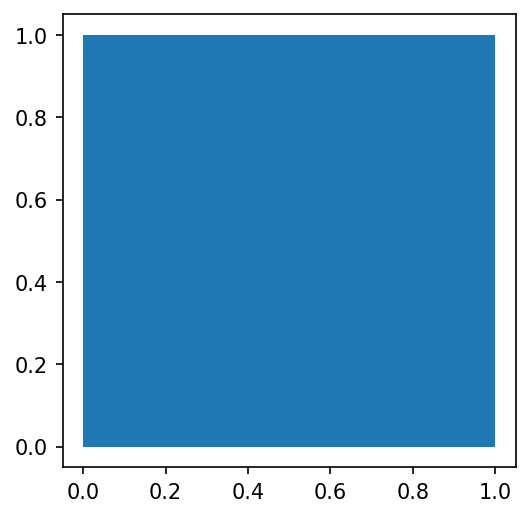

In [7]:
# plt.plot(*box.exterior.xy)
p = geopandas.GeoSeries(box); p.plot(); plt.show()

In [8]:
import pystare

In [18]:
cover_resolution=12
box_cover = pystare.from_polygon(box,resolution=cover_resolution,nonconvex=True)


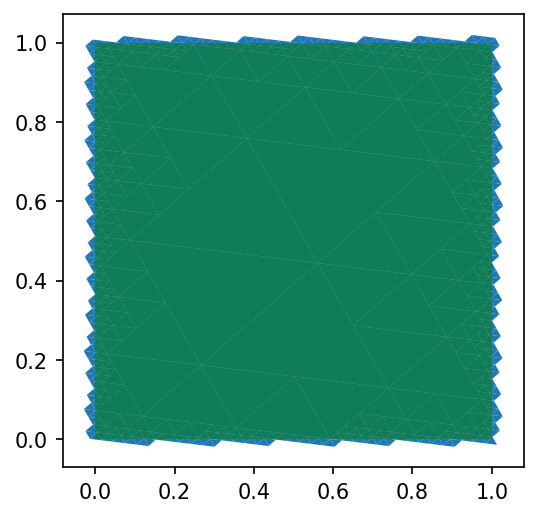

In [19]:
geoms = pystare.to_trixels(box_cover)
ax = geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot()
p.plot(ax=ax,color='green',alpha=0.5)
plt.show()

Note that box_cover is a little larger than box and will contain more points, as we see below.

In [42]:
# N = 10_000_000
N = 1_000
points_x = numpy.random.randn(N)
points_y = numpy.random.randn(N)

In [43]:
points   = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(points_x,points_y))
points_s = pystare.from_latlon(points_x,points_y,27)

In [48]:
%timeit points.within(box)
pob1 = points.within(box)

7.48 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit pob2 = pystare.intersects(box_cover,points_s,1)
pob2 = pystare.intersects(box_cover,points_s,1)

5.81 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
print('true 1,2: ',pob1.sum(),sum(pob2))

true 1,2:  107 112


In [34]:
# for i in range(N):
#    print(i,pob1[i],pob2[i])

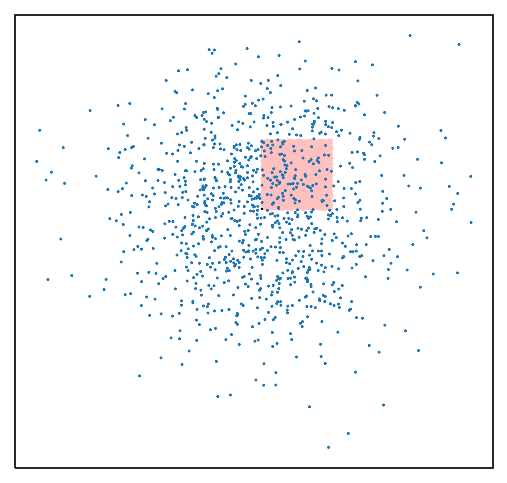

In [53]:
figax = hello_plot(points_s,show=False)
# p.plot(ax=figax.ax,color='green',alpha=0.5)
geopandas.GeoDataFrame({'geom':geoms}).set_geometry('geom').plot(ax = figax.ax,alpha=0.25,color='red')
plt.show()

4.554424424373931

Reference.

https://github.com/jsignell/dask-geopandas/blob/master/notebooks/basic-intro.ipynb
